<a href="https://colab.research.google.com/github/dvu4/grid_folium/blob/master/Copy_of_Face_alignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face alignment
This notebook tries two variations of a face-alignment algorithm.

The following bit of code loads some utilities and defines some useful functions.

In [0]:
from PIL import Image
import numpy as np
import dlib
import cv2
from pathlib import Path
from os import path
import os
import glob

LEFT_EYE_INDICES = [36, 37, 38, 39, 40, 41]
RIGHT_EYE_INDICES = [42, 43, 44, 45, 46, 47]

def rect_to_tuple(rect):
  left = rect.left()
  right = rect.right()
  top = rect.top()
  bottom = rect.bottom()
  return left, top, right, bottom

def extract_eye(shape, eye_indices):
  points = map(lambda i: shape.part(i), eye_indices)
  return list(points)

def extract_eye_center(shape, eye_indices):
  points = extract_eye(shape, eye_indices)
  xs = map(lambda p: p.x, points)
  ys = map(lambda p: p.y, points)
  return sum(xs) // 6, sum(ys) // 6

def extract_left_eye_center(shape):
  return extract_eye_center(shape, LEFT_EYE_INDICES)

def extract_right_eye_center(shape):
  return extract_eye_center(shape, RIGHT_EYE_INDICES)

def angle_between_2_points(p1, p2):
  x1, y1 = p1
  x2, y2 = p2
  tan = (y2 - y1) / (x2 - x1)
  return np.degrees(np.arctan(tan))

def get_rotation_matrix(p1, p2):
  angle = angle_between_2_points(p1, p2)
  x1, y1 = p1
  x2, y2 = p2
  xc = (x1 + x2) // 2
  yc = (y1 + y2) // 2
  M = cv2.getRotationMatrix2D((xc, yc), angle, 1)
  return M

def crop_image(image, det):
  left, top, right, bottom = rect_to_tuple(det)
  return image[top:bottom, left:right]

The following bit of code downloads a dlib shape predictor for faces. It will allow us to identify landmarks from faces.



In [0]:
import urllib.request
import bz2
urllib.request.urlretrieve("https://github.com/davisking/dlib-models/raw/master/shape_predictor_68_face_landmarks.dat.bz2", "shape_predictor_68_face_landmarks.dat.bz2")
fp1 = bz2.BZ2File("shape_predictor_68_face_landmarks.dat.bz2", "rb")
fp2 = open("shape_predictor_68_face_landmarks.dat", "wb")
for data in iter(lambda : fp1.read(100 * 1024), b''):
  fp2.write(data)
fp1.close()
fp2.close()

This bit of code asks the user to upload a file.

In [0]:
from google.colab import files

uploaded = files.upload()

names = []
for fn in uploaded.keys():
  names.append(fn)
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving 30_0_0_20170104201841050.jpg to 30_0_0_20170104201841050.jpg
User uploaded file "30_0_0_20170104201841050.jpg" with length 19096 bytes


## First version
This algorithm works as follows:
* The bounding box of the face is detected.
* The face is rotated so that the eyes are aligned horizontaly.
* The bounding box of the face is detected again.
* The face is cropped with a certain margin (more margin on top than on the bottom).

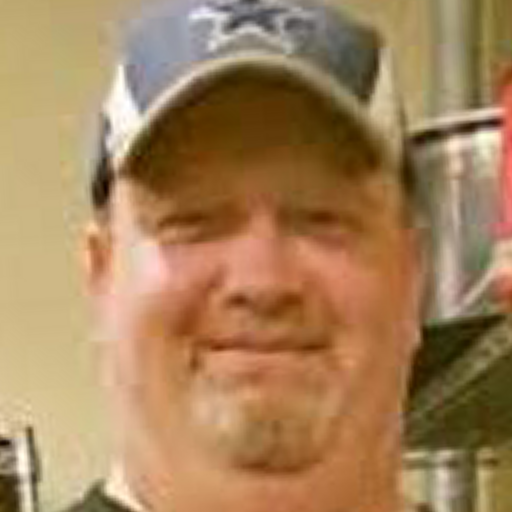

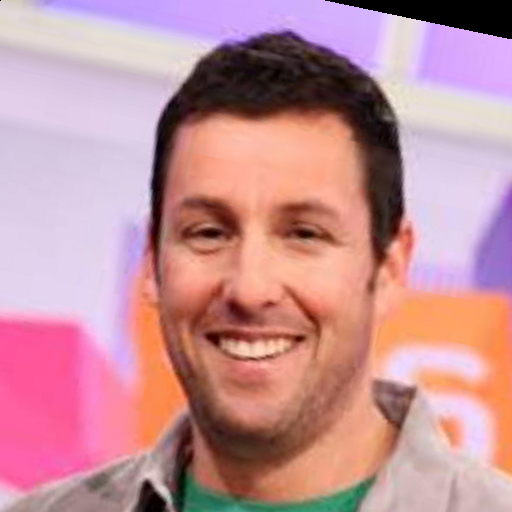

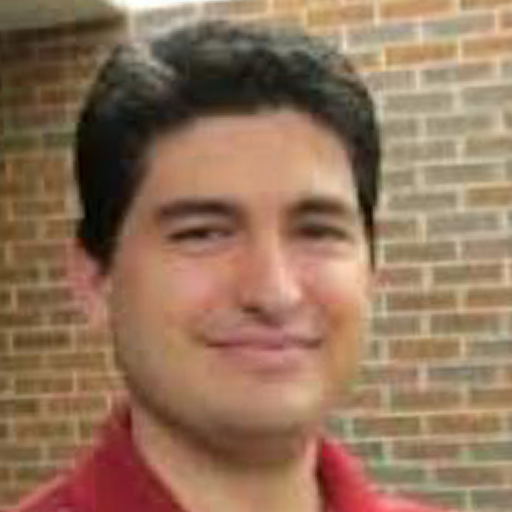

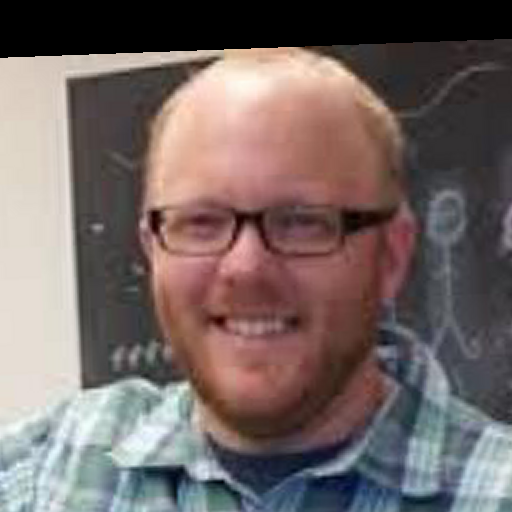

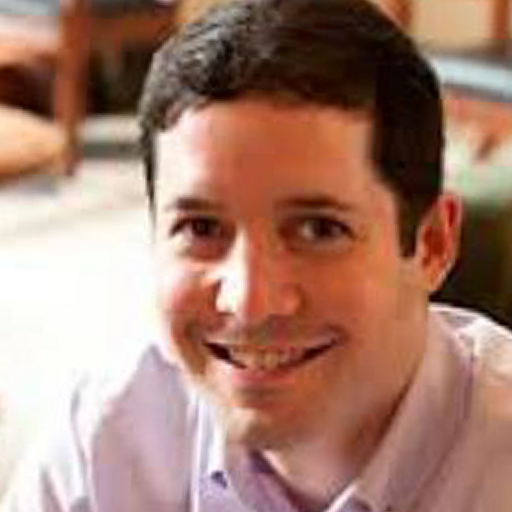

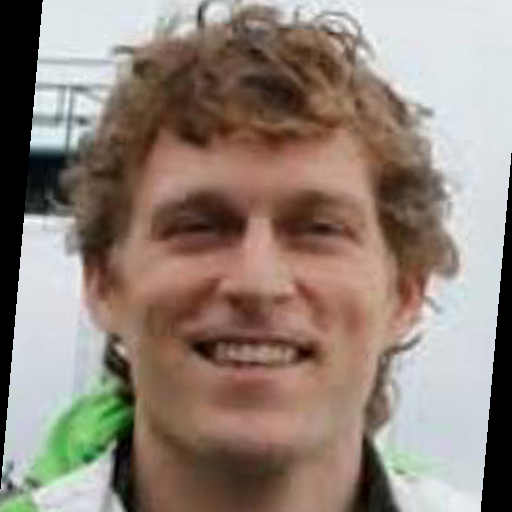

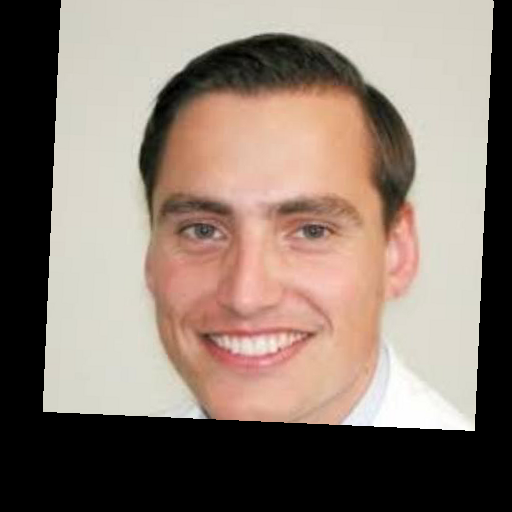

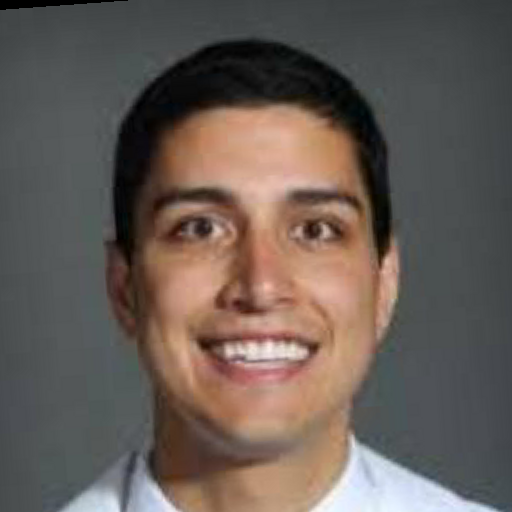

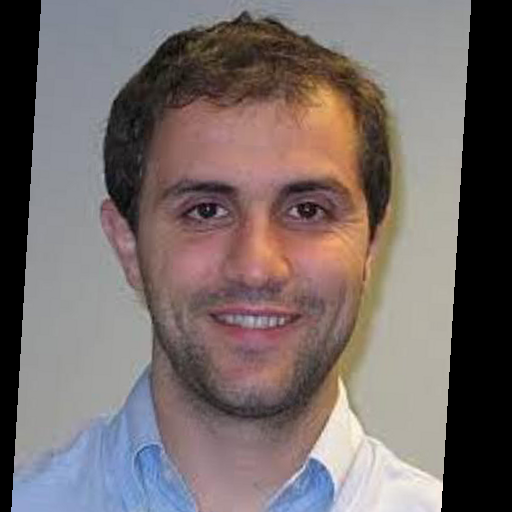

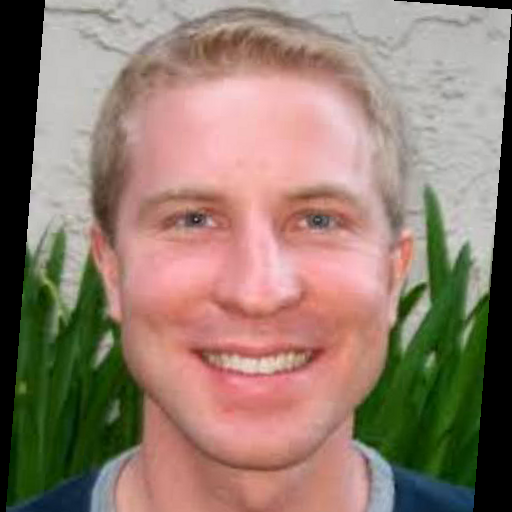

In [0]:
from IPython.display import display

side = 512 / (1 + 0.5 * 2)
padding = 0.5

recheck = True

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

for name in names:
  img = Image.open(name)
  img_gray = img.convert("L")
  img_array = np.asarray(img_gray)
  dets = detector(img_array, 1)
  if len(dets) == 0:
    print("No faces detected.")
  elif len(dets) > 1:
    print("Multiple faces detected.")
  else:
    det = dets[0]
    shape = predictor(img_array, det)
    left_eye = extract_left_eye_center(shape)
    right_eye = extract_right_eye_center(shape)
    M = get_rotation_matrix(left_eye, right_eye)
    M = np.linalg.inv(np.concatenate((M, [[0, 0, 1]])))
    if recheck:
      img_array = np.asarray(img_gray.transform((img.width, img.height), Image.AFFINE, M[:2].flatten()))
      det = detector(img_array, 1)[0]
      center = (left_eye[0] + right_eye[0]) / 2
      det_center = (det.left() + det.right()) / 2
      shift = det_center - center
      det = (det.left() - shift, det.top(), det.right() - shift, det.bottom())
    m = padding * (det[3] - det[1])
    t1 = det[0] - m
    t2 = det[1] - m * 1.2
    s1 = (det[2] - det[0] + m * 2) / (side + side * padding * 2)
    s2 = (det[3] - det[1] + m * 2) / (side + side * padding * 2)
    M = M @ np.array([[s1, 0, t1], [0, s2, t2], [0, 0, 1]])
    face = img.transform((round(side + side * padding * 2), round(side + side * padding * 2)), Image.AFFINE, M[:2].flatten(), resample=Image.BICUBIC)
    display(face)

## Second version
This algorithm works as follows:
* The bounding box of the face is detected.
* The face is rotated so that the eyes are aligned horizontaly.
* The face is resized and shifted to keep the eyes always in the same exact position.

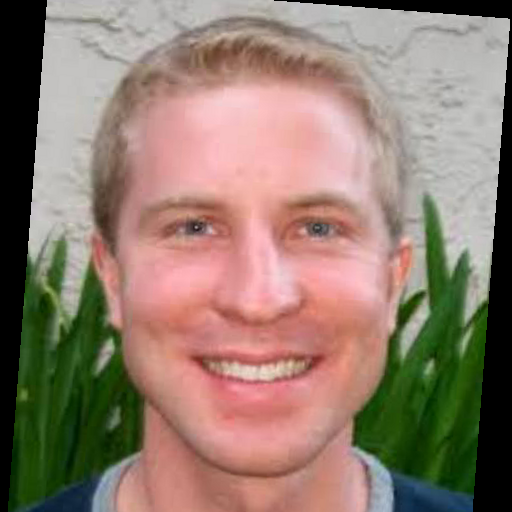

In [0]:
from IPython.display import display
from math import sqrt

side = 512 / (1 + 0.5 * 2)
padding = 0.5

recheck = True

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

for name in names:
  img = Image.open(name)
  img_gray = img.convert("L")
  img_array = np.asarray(img_gray)
  dets = detector(img_array, 1)
  if len(dets) == 0:
    print("No faces detected.")
  elif len(dets) > 1:
    print("Multiple faces detected.")
  else:
    det = dets[0]
    shape = predictor(img_array, det)
    left_eye = extract_left_eye_center(shape)
    right_eye = extract_right_eye_center(shape)
    M = get_rotation_matrix(left_eye, right_eye)
    M = np.linalg.inv(np.concatenate((M, [[0, 0, 1]])))
    if recheck:
      img_array = np.asarray(img_gray.transform((img.width, img.height), Image.AFFINE, M[:2].flatten()))
      det = detector(img_array, 1)[0]
      center_x = (left_eye[0] + right_eye[0]) / 2
      center_y = (left_eye[1] + right_eye[1]) / 2
      det_center = (det.left() + det.right()) / 2
      shift = det_center - center_x
      eyes_distance = sqrt((left_eye[0] - right_eye[0]) ** 2 + (left_eye[1] - right_eye[1]) ** 2)
      e = eyes_distance * 2.15
      det = (center_x - e * 0.5, center_y - e * 0.4, center_x + e * 0.5, center_y + e * 0.6)
    m = padding * (det[3] - det[1])
    t1 = det[0] - m
    t2 = det[1] - m
    s1 = (det[2] - det[0] + m * 2) / (side + side * padding * 2)
    s2 = (det[3] - det[1] + m * 2) / (side + side * padding * 2)
    M = M @ np.array([[s1, 0, t1], [0, s2, t2], [0, 0, 1]])
    face = img.transform((round(side + side * padding * 2), round(side + side * padding * 2)), Image.AFFINE, M[:2].flatten(), resample=Image.BICUBIC)
    display(face)